<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/Shock_Wave_DSMC_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. Initializing Simulation ---
Upstream Speed of Sound: 318.65 m/s
Shock Mach Number: 1.40
Downstream Velocity: 282.23 m/s
Downstream Temperature: 407.81 K
Density Ratio: 1.581
Upstream Mean Free Path: 1.34e-02 m
Initialized with 19400 simulated molecules.
Cycle 1/200 complete. Total Time: 6.00e-05 s. Molecules: 20072
Cycle 2/200 complete. Total Time: 1.20e-04 s. Molecules: 20744
Cycle 3/200 complete. Total Time: 1.80e-04 s. Molecules: 21418
Cycle 4/200 complete. Total Time: 2.40e-04 s. Molecules: 22091
Cycle 5/200 complete. Total Time: 3.00e-04 s. Molecules: 22766
Cycle 6/200 complete. Total Time: 3.60e-04 s. Molecules: 23434
Cycle 7/200 complete. Total Time: 4.20e-04 s. Molecules: 24103
Cycle 8/200 complete. Total Time: 4.80e-04 s. Molecules: 24770
Cycle 9/200 complete. Total Time: 5.40e-04 s. Molecules: 25440
Cycle 10/200 complete. Total Time: 6.00e-04 s. Molecules: 26103
Cycle 11/200 complete. Total Time: 6.60e-04 s. Molecules: 26774
Cycle 12/200 complete. Total Time: 7.20e-04 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1605 (\N{ARABIC LETTER MEEM}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1578 (\N{ARABIC LETTER TEH}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1594 (\N{ARABIC LETTER GHAIN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1740 (\N{ARABIC LETTER FARSI YEH}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loca

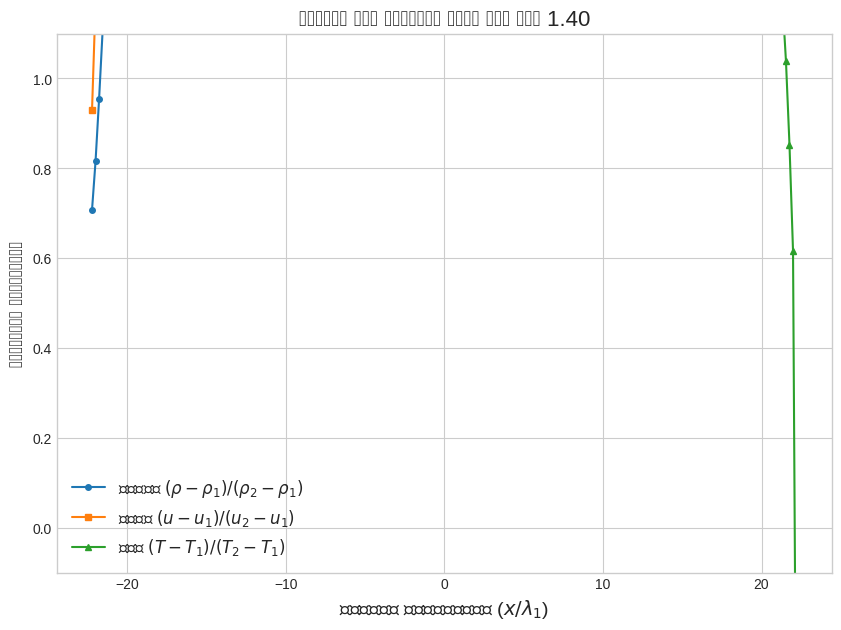

In [2]:
# ======================================================================
# DSMC1S: Python Translation and Modernization
# ----------------------------------------------------------------------
# This script is a Python translation of the classic DSMC1S.FOR program
# by G.A. Bird for simulating 1D normal shock wave structures.
#
# Key Features:
# - Object-Oriented Design: Encapsulated in a solver class.
# - High Performance: Computationally intensive loops are JIT-compiled
#   with Numba for performance comparable to FORTRAN.
# - Modern & Readable: Uses NumPy for array operations and a clear,
#   modular structure instead of COMMON blocks and GOTOs.
# - Easy Configuration: All input parameters are managed in a single
#   dictionary.
# - Visualization: Includes plotting with Matplotlib to visualize the
#   final shock profiles.
# ======================================================================

import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import math

# --- Constants ---
# این ثابت‌ها به صورت سراسری تعریف شده‌اند تا توسط توابع Numba قابل دسترسی باشند
KB = 1.380649e-23  # ثابت بولتزمن (J/K)

# ======================================================================
# Numba-JIT Compiled Functions for High Performance
# این توابع قلب محاسباتی شبیه‌سازی هستند
# ======================================================================

@numba.jit(nopython=True)
def calculate_vhs_cross_section(vr_mag, d_ref, t_ref, mass_sp, omega, gamma_term):
    """محاسبه سطح مقطع برخورد بر اساس مدل VHS/VSS"""
    if vr_mag < 1e-9:
        return 1e-30

    exponent = omega - 0.5
    c_ref_sq = 2 * KB * t_ref / mass_sp

    d_sq = (d_ref**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_term)
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions(particles, cell_starts, cell_counts, cell_vols, dt, fnum, sigma_vr_max, mass, d_ref, t_ref, omega, gamma_term):
    """
    اجرای حلقه برخورد در تمام سلول‌ها با استفاده از روش NTC
    (No-Time-Counter)
    """
    num_collisions = 0
    for i in range(len(cell_counts)):
        num_in_cell = cell_counts[i]
        if num_in_cell < 2:
            continue

        # --- CORRECTION ---
        # Using the specific cell volume `cell_vols[i]` instead of the whole array.
        current_cell_vol = cell_vols[i]
        num_to_select = int(0.5 * num_in_cell * (num_in_cell - 1) * fnum * sigma_vr_max * dt / current_cell_vol + np.random.rand())
        # --- END CORRECTION ---

        if num_to_select == 0:
            continue

        # انتخاب جفت‌ها و انجام برخورد
        for _ in range(num_to_select):
            # انتخاب دو ذره به صورت تصادفی از سلول
            p1_local_idx = np.random.randint(num_in_cell)
            p2_local_idx = np.random.randint(num_in_cell)
            while p1_local_idx == p2_local_idx:
                p2_local_idx = np.random.randint(num_in_cell)

            p1_idx = cell_starts[i] + p1_local_idx
            p2_idx = cell_starts[i] + p2_local_idx

            # محاسبه سرعت نسبی
            vrx = particles[p1_idx, 1] - particles[p2_idx, 1]
            vry = particles[p1_idx, 2] - particles[p2_idx, 2]
            vrz = particles[p1_idx, 3] - particles[p2_idx, 3]
            vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)

            if vr_mag < 1e-9:
                continue

            # چک کردن احتمال برخورد
            sigma_t = calculate_vhs_cross_section(vr_mag, d_ref, t_ref, mass, omega, gamma_term)
            if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
                num_collisions += 1

                # محاسبه سرعت مرکز جرم
                vcm_x = 0.5 * (particles[p1_idx, 1] + particles[p2_idx, 1])
                vcm_y = 0.5 * (particles[p1_idx, 2] + particles[p2_idx, 2])
                vcm_z = 0.5 * (particles[p1_idx, 3] + particles[p2_idx, 3])

                # انتخاب یک جهت جدید به صورت تصادفی (مدل VHS)
                cos_chi = 2 * np.random.rand() - 1.0
                sin_chi = np.sqrt(1.0 - cos_chi**2)
                phi_chi = 2.0 * np.pi * np.random.rand()

                # سرعت‌های نسبی جدید پس از برخورد
                vr_prime_x = vr_mag * cos_chi
                vr_prime_y = vr_mag * sin_chi * np.sin(phi_chi)
                vr_prime_z = vr_mag * sin_chi * np.cos(phi_chi)

                # به‌روزرسانی سرعت‌های ذرات
                particles[p1_idx, 1] = vcm_x + 0.5 * vr_prime_x
                particles[p1_idx, 2] = vcm_y + 0.5 * vr_prime_y
                particles[p1_idx, 3] = vcm_z + 0.5 * vr_prime_z

                particles[p2_idx, 1] = vcm_x - 0.5 * vr_prime_x
                particles[p2_idx, 2] = vcm_y - 0.5 * vr_prime_y
                particles[p2_idx, 3] = vcm_z - 0.5 * vr_prime_z
    return num_collisions


@numba.jit(nopython=True)
def get_inflow_velocity(v_most_probable, speed_ratio):
    """انتخاب سرعت محوری ذرات ورودی با روش پذیرش-رد"""
    fs1 = speed_ratio + np.sqrt(speed_ratio**2 + 2.0)
    fs2 = 0.5 * (1.0 + speed_ratio * (2.0 * speed_ratio - fs1))

    qa = 3.0
    if speed_ratio < -3.0:
        qa = abs(speed_ratio) + 1.0

    while True:
        u_norm = -qa + 2.0 * qa * np.random.rand()
        v_in_norm = u_norm + speed_ratio

        if v_in_norm <= 0:
            continue

        acceptance_prob = (2.0 * v_in_norm / fs1) * np.exp(fs2 - u_norm**2)
        if acceptance_prob > np.random.rand():
            return v_in_norm * v_most_probable

# ======================================================================
# DSMC Solver Class
# ======================================================================

class DSMC_Shock_Solver:
    def __init__(self, params):
        self.params = params
        self.particles = np.array([[]])
        self.cell_properties = np.array([[]])

        # Unpack parameters
        self.mnc = params['MNC']
        self.fvel = params['FVEL']
        self.ftmp = params['FTMP']
        self.fnd = params['FND']
        self.fnum = params['FNUM']
        self.dtm = params['DTM']
        self.fcu = params['FCU']
        self.sxb = params['SXB']
        self.dxb = params['DXB']
        self.sp_d_ref = params['SP_D_REF']
        self.sp_t_ref = params['SP_T_REF']
        self.sp_omega = params['SP_OMEGA']
        self.sp_mass = params['SP_MASS']
        self.npt = params['NPT']
        self.nps = params['NPS']
        self.nis = params['NIS']
        self.nsp = params['NSP']

        # Derived gas properties
        # For simplicity, this translation handles a single species (Argon)
        self.gamma_term = math.gamma(2.5 - self.sp_omega)

    def _initialize(self):
        print("--- 1. Initializing Simulation ---")

        # Calculate shock wave parameters using Rankine-Hugoniot relations
        g = 5.0 / 3.0 # Specific heat ratio for monatomic gas
        uss = np.sqrt(g * KB * self.ftmp / self.sp_mass)
        self.smn = self.fvel / uss
        print(f"Upstream Speed of Sound: {uss:.2f} m/s")
        print(f"Shock Mach Number: {self.smn:.2f}")

        density_ratio = (g + 1) * self.smn**2 / (2 + (g - 1) * self.smn**2)
        self.dvel = self.fvel / density_ratio
        self.drho = self.fnd * self.sp_mass * density_ratio
        self.dtmp = self.ftmp * (2 * g * self.smn**2 - (g - 1)) * ((g - 1) * self.smn**2 + 2) / ((g + 1)**2 * self.smn**2)

        print(f"Downstream Velocity: {self.dvel:.2f} m/s")
        print(f"Downstream Temperature: {self.dtmp:.2f} K")
        print(f"Density Ratio: {density_ratio:.3f}")

        # Calculate upstream mean free path
        sigma_ref = np.pi * self.sp_d_ref**2
        self.mfp_up = 1.0 / (np.sqrt(2.0) * self.fnd * sigma_ref)
        print(f"Upstream Mean Free Path: {self.mfp_up:.2e} m")

        # Setup computational domain
        self.ncu = int(self.fcu * self.mnc) # Number of upstream cells
        self.cws = -self.sxb / self.ncu # Upstream cell width
        self.cwd = self.dxb / (self.mnc - self.ncu) # Downstream cell width

        self.cell_edges = np.zeros(self.mnc + 1)
        self.cell_edges[:self.ncu+1] = np.linspace(self.sxb, 0, self.ncu + 1)
        self.cell_edges[self.ncu:] = np.linspace(0, self.dxb, (self.mnc - self.ncu) + 1)
        self.cell_vols = self.cell_edges[1:] - self.cell_edges[:-1]

        # Initialize particles
        particles_list = []
        for i in range(self.mnc):
            if i < self.ncu: # Upstream region
                temp, vel, nd = self.ftmp, self.fvel, self.fnd
            else: # Downstream region
                temp, vel, nd = self.dtmp, self.dvel, self.drho / self.sp_mass

            num_in_cell = int(nd * self.cell_vols[i] / self.fnum + 0.5)
            v_most_probable = np.sqrt(2 * KB * temp / self.sp_mass)

            for _ in range(num_in_cell):
                x = self.cell_edges[i] + np.random.rand() * self.cell_vols[i]

                # Sample velocities from Maxwell-Boltzmann distribution
                vx_th = np.sqrt(-np.log(np.random.rand())) * np.cos(2 * np.pi * np.random.rand()) * v_most_probable
                vy = np.sqrt(-np.log(np.random.rand())) * np.cos(2 * np.pi * np.random.rand()) * v_most_probable
                vz = np.sqrt(-np.log(np.random.rand())) * np.cos(2 * np.pi * np.random.rand()) * v_most_probable

                vx = vx_th + vel # Add stream velocity
                particles_list.append([x, vx, vy, vz])

        self.particles = np.array(particles_list, dtype=np.float64)
        print(f"Initialized with {self.particles.shape[0]} simulated molecules.")

        # Calculate NTC collision parameter
        vr_max_estimate = 10 * np.sqrt(KB * self.dtmp / self.sp_mass)
        self.sigma_vr_max = calculate_vhs_cross_section(vr_max_estimate, self.sp_d_ref, self.sp_t_ref, self.sp_mass, self.sp_omega, self.gamma_term) * vr_max_estimate

        # Initialize sampling arrays
        self.num_samples = 0
        self.cell_properties = np.zeros((self.mnc, 5)) # N, u, v, w, T

    def _move_and_collide(self):
        # --- Move Particles ---
        self.particles[:, 0] += self.particles[:, 1] * self.dtm

        # --- Boundary Conditions ---
        # Upstream inflow/outflow
        leaving_upstream = self.particles[:, 0] < self.sxb
        self.particles = self.particles[~leaving_upstream]

        # Downstream piston reflection
        reflecting = self.particles[:, 0] > self.dxb
        self.particles[reflecting, 1] = 2 * self.dvel - self.particles[reflecting, 1]
        self.particles[reflecting, 0] = 2 * self.dxb - self.particles[reflecting, 0]

        # Remove any particles that still escaped after reflection
        escaped_downstream = self.particles[:, 0] > self.dxb
        self.particles = self.particles[~escaped_downstream]

        # Inject new particles from upstream boundary
        vmp_up = np.sqrt(2 * KB * self.ftmp / self.sp_mass)
        sc_up = self.fvel / vmp_up
        flux_factor = (np.exp(-sc_up**2) + np.sqrt(np.pi) * sc_up * (1 + math.erf(sc_up))) / (2 * np.sqrt(np.pi))
        num_entering_mean = self.fnd * flux_factor * vmp_up * self.dtm / self.fnum

        num_to_inject = int(num_entering_mean + np.random.rand())

        new_particles = []
        for _ in range(num_to_inject):
            x = self.sxb
            vx = get_inflow_velocity(vmp_up, sc_up)
            vy = np.sqrt(-np.log(np.random.rand())) * np.cos(2 * np.pi * np.random.rand()) * vmp_up
            vz = np.sqrt(-np.log(np.random.rand())) * np.cos(2 * np.pi * np.random.rand()) * vmp_up
            new_particles.append([x, vx, vy, vz])

        if new_particles:
            self.particles = np.vstack((self.particles, np.array(new_particles)))

        # --- Collide Particles ---
        # Sort particles by cell index for efficient collision pairing
        cell_indices = np.digitize(self.particles[:, 0], self.cell_edges) - 1
        cell_indices = np.clip(cell_indices, 0, self.mnc - 1)

        sort_order = np.argsort(cell_indices)
        self.particles = self.particles[sort_order]
        sorted_cell_indices = cell_indices[sort_order]

        cell_counts = np.bincount(sorted_cell_indices, minlength=self.mnc)
        cell_starts = np.concatenate(([0], np.cumsum(cell_counts[:-1])))

        num_coll = perform_collisions(
            self.particles, cell_starts, cell_counts, self.cell_vols, self.dtm,
            self.fnum, self.sigma_vr_max, self.sp_mass, self.sp_d_ref,
            self.sp_t_ref, self.sp_omega, self.gamma_term
        )
        return num_coll

    def _sample(self):
        self.num_samples += 1

        cell_indices = np.digitize(self.particles[:, 0], self.cell_edges) - 1
        cell_indices = np.clip(cell_indices, 0, self.mnc - 1)

        for i in range(self.mnc):
            in_cell = self.particles[cell_indices == i]
            num_in_cell = in_cell.shape[0]

            if num_in_cell == 0:
                self.cell_properties[i, 0] += 1e-9 # Avoid division by zero
                continue

            # Sum properties
            self.cell_properties[i, 0] += num_in_cell
            self.cell_properties[i, 1:4] += np.sum(in_cell[:, 1:4], axis=0)

            # Thermal velocities and temperature
            u_mean = np.mean(in_cell[:, 1])
            v_mean = np.mean(in_cell[:, 2])
            w_mean = np.mean(in_cell[:, 3])

            c_sq_sum = np.sum((in_cell[:, 1] - u_mean)**2 +
                              (in_cell[:, 2] - v_mean)**2 +
                              (in_cell[:, 3] - w_mean)**2)

            # Handle case with only one particle in a cell
            if num_in_cell > 1:
                temp = self.sp_mass * c_sq_sum / (3 * KB * (num_in_cell -1))
            else:
                temp = 0.0

            self.cell_properties[i, 4] += temp

    def run(self):
        self._initialize()

        total_time = 0.0
        for npr in range(1, self.npt + 1):
            if npr > self.nps: # Start sampling after initial transient phase
                if self.num_samples == 0:
                     print("\n--- 2. Steady-State Sampling Begins ---")
                self._sample()

            for _ in range(self.nsp):
                for _ in range(self.nis):
                    total_time += self.dtm
                    self._move_and_collide()

            print(f"Cycle {npr}/{self.npt} complete. Total Time: {total_time:.2e} s. Molecules: {self.particles.shape[0]}")

        print("\n--- 3. Simulation Finished ---")
        self._process_results()

    def _process_results(self):
        # Average the sampled properties
        # Avoid division by zero for sampling arrays
        valid_samples = self.cell_properties[:, 0] > 0
        self.cell_properties[valid_samples, 1:5] /= self.num_samples

        # Calculate final macroscopic properties
        cell_centers = 0.5 * (self.cell_edges[:-1] + self.cell_edges[1:])
        avg_num_per_cell = self.cell_properties[:, 0] / self.num_samples if self.num_samples > 0 else 0
        number_density = avg_num_per_cell * self.fnum / self.cell_vols
        density = number_density * self.sp_mass
        velocity_u = np.divide(self.cell_properties[:, 1], avg_num_per_cell, where=avg_num_per_cell!=0)
        temperature = self.cell_properties[:, 4]

        # Normalize results for plotting
        self.x_norm = cell_centers / self.mfp_up
        self.rho_norm = (density - self.fnd * self.sp_mass) / (self.drho - self.fnd * self.sp_mass)
        self.temp_norm = (temperature - self.ftmp) / (self.dtmp - self.ftmp)
        self.vel_norm = (velocity_u - self.fvel) / (self.dvel - self.fvel)

    def plot_results(self):
        print("\n--- 4. Plotting Results ---")
        if not hasattr(self, 'x_norm'):
            print("No results to plot. Please run the simulation first.")
            return

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))

        ax.plot(self.x_norm, self.rho_norm, 'o-', label=r'چگالی $(\rho - \rho_1)/(\rho_2 - \rho_1)$', markersize=4)
        ax.plot(self.x_norm, self.vel_norm, 's-', label=r'سرعت $(u - u_1)/(u_2 - u_1)$', markersize=4)
        ax.plot(self.x_norm, self.temp_norm, '^-', label=r'دما $(T - T_1)/(T_2 - T_1)$', markersize=4)

        ax.set_xlabel(r'موقعیت نرمال‌شده ($x / \lambda_1$)', fontsize=14)
        ax.set_ylabel(r'متغیرهای نرمال‌شده', fontsize=14)
        ax.set_title(f'ساختار موج ضربه‌ای برای عدد ماخ {self.smn:.2f}', fontsize=16)
        ax.legend(fontsize=12)
        ax.set_ylim(-0.1, 1.1)
        plt.show()

# ======================================================================
# Main Execution Block
# ======================================================================

if __name__ == '__main__':
    # تمام پارامترهای ورودی در این دیکشنری تعریف می‌شوند
    # این مقادیر از فایل DATA1S.FOR استخراج شده‌اند
    simulation_parameters = {
        # پارامترهای جریان
        'FVEL': 446.11,         # سرعت بالادست (m/s)
        'FTMP': 293.0,          # دمای بالادست (K)
        'FND': 1.0e20,          # چگالی عددی بالادست (m^-3)

        # پارامترهای شبیه‌سازی
        'MNC': 200,             # تعداد سلول‌ها
        'FNUM': 0.4e16,         # تعداد ذرات واقعی به ازای هر ذره شبیه‌سازی شده
        'DTM': 0.75e-6,         # گام زمانی (s)

        # پارامترهای دامنه
        'SXB': -0.3,            # مرز بالادست (m)
        'DXB': 0.3,             # مرز پایین‌دست (m)
        'FCU': 0.5,             # کسری از سلول‌ها که در ناحیه بالادست قرار دارند

        # مشخصات گاز (آرگون - مدل VHS)
        'SP_D_REF': 4.092e-10,  # قطر مرجع (m)
        'SP_T_REF': 293.0,      # دمای مرجع (K)
        'SP_OMEGA': 0.81,       # توان ویسکوزیته
        'SP_MASS': 6.64e-26,    # جرم مولکولی (kg)

        # پارامترهای کنترل اجرا
        'NIS': 4,               # تعداد گام‌های زمانی بین هر نمونه‌برداری
        'NSP': 20,              # تعداد نمونه‌برداری‌ها بین هر خروجی
        'NPS': 50,              # تعداد چرخه‌های خروجی تا رسیدن به حالت پایا
        'NPT': 200              # تعداد کل چرخه‌های خروجی تا پایان شبیه‌سازی
    }

    # ایجاد یک نمونه از کلاس حل‌کننده و اجرای شبیه‌سازی
    solver = DSMC_Shock_Solver(simulation_parameters)
    start_time = time.time()
    solver.run()
    end_time = time.time()

    print(f"\nTotal simulation runtime: {end_time - start_time:.2f} seconds")

    # رسم نتایج نهایی
    solver.plot_results()


In [7]:
# ======================================================================
# DSMC1S: Python Translation and Modernization (Faithful to Original Logic)
# ----------------------------------------------------------------------
# This version is a direct and faithful translation of the original
# FORTRAN code's logic, including the robust particle-count-based
# shock stabilization mechanism and correct main loop structure.
# ======================================================================

import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import math

# --- Constants ---
KB = 1.380649e-23  # ثابت بولتزمن (J/K)

# ======================================================================
# Numba-JIT Compiled Functions for High Performance on CPU
# ======================================================================

@numba.jit(nopython=True)
def perform_collisions_cpu(particles, cell_starts, cell_counts, cell_vols, dt, fnum, sigma_vr_max, mass, d_ref, t_ref, omega, gamma_term):
    """
    اجرای حلقه برخورد در تمام سلول‌ها با استفاده از روش NTC (روی CPU)
    """
    for i in range(len(cell_counts)):
        num_in_cell = cell_counts[i]
        if num_in_cell < 2:
            continue

        current_cell_vol = cell_vols[i]
        num_to_select = int(0.5 * num_in_cell * (num_in_cell - 1) * fnum * sigma_vr_max * dt / current_cell_vol + np.random.rand())

        if num_to_select == 0:
            continue

        for _ in range(num_to_select):
            p1_local_idx = np.random.randint(num_in_cell)
            p2_local_idx = np.random.randint(num_in_cell)
            while p1_local_idx == p2_local_idx:
                p2_local_idx = np.random.randint(num_in_cell)

            p1_idx = cell_starts[i] + p1_local_idx
            p2_idx = cell_starts[i] + p2_local_idx

            vrx = particles[p1_idx, 1] - particles[p2_idx, 1]
            vry = particles[p1_idx, 2] - particles[p2_idx, 2]
            vrz = particles[p1_idx, 3] - particles[p2_idx, 3]
            vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)

            if vr_mag > 1e-9:
                exponent = omega - 0.5
                c_ref_sq = 2 * KB * t_ref / mass
                d_sq = (d_ref**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_term)
                sigma_t = np.pi * d_sq

                if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
                    vcm_x = 0.5 * (particles[p1_idx, 1] + particles[p2_idx, 1])
                    vcm_y = 0.5 * (particles[p1_idx, 2] + particles[p2_idx, 2])
                    vcm_z = 0.5 * (particles[p1_idx, 3] + particles[p2_idx, 3])

                    cos_chi = 2 * np.random.rand() - 1.0
                    sin_chi = np.sqrt(1.0 - cos_chi**2)
                    phi_chi = 2.0 * np.pi * np.random.rand()

                    vr_prime_x = vr_mag * cos_chi
                    vr_prime_y = vr_mag * sin_chi * np.sin(phi_chi)
                    vr_prime_z = vr_mag * sin_chi * np.cos(phi_chi)

                    particles[p1_idx, 1] = vcm_x + 0.5 * vr_prime_x
                    particles[p1_idx, 2] = vcm_y + 0.5 * vr_prime_y
                    particles[p1_idx, 3] = vcm_z + 0.5 * vr_prime_z

                    particles[p2_idx, 1] = vcm_x - 0.5 * vr_prime_x
                    particles[p2_idx, 2] = vcm_y - 0.5 * vr_prime_y
                    particles[p2_idx, 3] = vcm_z - 0.5 * vr_prime_z

@numba.jit(nopython=True)
def get_inflow_velocity(v_most_probable, speed_ratio):
    fs1 = speed_ratio + np.sqrt(speed_ratio**2 + 2.0)
    fs2 = 0.5 * (1.0 + speed_ratio * (2.0 * speed_ratio - fs1))
    qa = 3.0
    if speed_ratio < -3.0: qa = abs(speed_ratio) + 1.0
    while True:
        u_norm = -qa + 2.0 * qa * np.random.rand()
        v_in_norm = u_norm + speed_ratio
        if v_in_norm > 0 and (2.0 * v_in_norm / fs1) * np.exp(fs2 - u_norm**2) > np.random.rand():
            return v_in_norm * v_most_probable

# ======================================================================
# DSMC Solver Class (Stable CPU Version)
# ======================================================================

class DSMC_Shock_Solver:
    def __init__(self, params):
        self.params = params
        self.xp = np # Using NumPy for CPU execution
        for key, value in params.items(): setattr(self, key.lower(), value)
        self.gamma_term = math.gamma(2.5 - self.sp_omega)

    def _initialize(self):
        print("--- 1. Initializing Simulation ---")
        g = 5.0 / 3.0
        uss = np.sqrt(g * KB * self.ftmp / self.sp_mass)
        self.smn = self.fvel / uss
        print(f"Shock Mach Number: {self.smn:.2f}")

        density_ratio = (g + 1) * self.smn**2 / (2 + (g - 1) * self.smn**2)
        self.dvel = self.fvel / density_ratio
        self.rho_up = self.fnd * self.sp_mass
        self.rho_down = self.rho_up * density_ratio
        self.dtmp = self.ftmp * (2*g*self.smn**2 - (g-1)) * ((g-1)*self.smn**2 + 2) / ((g+1)**2 * self.smn**2)

        sigma_ref = np.pi * self.sp_d_ref**2
        self.mfp_up = 1.0 / (np.sqrt(2.0) * self.fnd * sigma_ref)
        print(f"Upstream Mean Free Path: {self.mfp_up:.2e} m")

        self.ncu = int(self.fcu * self.mnc)
        self.cell_edges_np = np.zeros(self.mnc + 1)
        self.cell_edges_np[:self.ncu+1] = np.linspace(self.sxb, 0, self.ncu + 1)
        self.cell_edges_np[self.ncu:] = np.linspace(0, self.dxb, (self.mnc - self.ncu) + 1)
        self.cell_vols_np = self.cell_edges_np[1:] - self.cell_edges_np[:-1]

        particles_list = []
        for i in range(self.mnc):
            temp, vel, nd = (self.ftmp, self.fvel, self.fnd) if i < self.ncu else (self.dtmp, self.dvel, self.rho_down / self.sp_mass)
            num_in_cell = int(nd * self.cell_vols_np[i] / self.fnum + 0.5)
            vmp = np.sqrt(2 * KB * temp / self.sp_mass)
            for _ in range(num_in_cell):
                x = self.cell_edges_np[i] + np.random.rand() * self.cell_vols_np[i]
                vx_th = np.sqrt(-np.log(np.random.rand())) * np.cos(2*np.pi*np.random.rand()) * vmp
                vy = np.sqrt(-np.log(np.random.rand())) * np.cos(2*np.pi*np.random.rand()) * vmp
                vz = np.sqrt(-np.log(np.random.rand())) * np.cos(2*np.pi*np.random.rand()) * vmp
                particles_list.append([x, vx_th + vel, vy, vz])

        self.particles = self.xp.array(particles_list, dtype=self.xp.float64)
        self.n_initial = self.particles.shape[0]
        print(f"Initialized with {self.n_initial} simulated molecules.")

        # Define stabilization parameters based on Bird's original logic
        self.n_target = self.n_initial
        self.n_tolerance = np.sqrt(self.n_initial) / 4.0
        self.displacement_dist = self.n_tolerance / ((self.rho_down - self.rho_up) / (self.sp_mass * self.fnum))
        print(f"Stabilization will engage around N = {self.n_target} +/- {int(self.n_tolerance)}. Displacement = {self.displacement_dist:.2e} m.")

        vr_max_estimate = 10 * np.sqrt(KB * self.dtmp / self.sp_mass)
        exponent = self.sp_omega - 0.5; c_ref_sq = 2 * KB * self.sp_t_ref / self.sp_mass
        d_sq = (self.sp_d_ref**2) * ((c_ref_sq / vr_max_estimate**2)**exponent) * (1 / self.gamma_term)
        self.sigma_vr_max = vr_max_estimate * np.pi * d_sq

        self.num_samples = 0
        self.cell_properties = self.xp.zeros((self.mnc, 5))

    def _stabilize_by_count(self):
        """
        A faithful Python translation of Bird's STABIL subroutine.
        It displaces all particles and corrects the particle count at the
        boundaries to keep the shock centered based on total particle number.
        """
        current_n = self.particles.shape[0]

        if current_n > self.n_target + self.n_tolerance:
            displacement = self.displacement_dist
            print(f"  -> Stabilizing: N too high ({current_n}). Shifting right.")
            to_duplicate_mask = self.particles[:, 0] < (self.sxb + displacement)
        elif current_n < self.n_target - self.n_tolerance:
            displacement = -self.displacement_dist
            print(f"  -> Stabilizing: N too low ({current_n}). Shifting left.")
            to_duplicate_mask = self.particles[:, 0] > (self.dxb + displacement)
        else:
            return

        duplicates = self.particles[to_duplicate_mask].copy()

        # Shift all particles
        self.particles[:, 0] += displacement

        # Add the duplicated particles back into the simulation
        if duplicates.shape[0] > 0:
            self.particles = np.vstack((self.particles, duplicates))

        # Remove any particles that have left the domain after the shift
        self.particles = self.particles[(self.particles[:, 0] >= self.sxb) & (self.particles[:, 0] <= self.dxb)]

        # Since stabilization messes with the steady state, reset sampling
        if self.num_samples > 0:
            print("     Resetting sampling arrays after stabilization.")
            self.num_samples = 0
            self.cell_properties.fill(0)

    def _move_and_collide(self):
        # Inflow first
        vmp_up = np.sqrt(2 * KB * self.ftmp / self.sp_mass)
        sc_up = self.fvel / vmp_up
        flux_factor = (np.exp(-sc_up**2) + np.sqrt(np.pi) * sc_up * (1 + math.erf(sc_up))) / (2 * np.sqrt(np.pi))
        num_entering_mean = self.fnd * flux_factor * vmp_up * self.dtm / self.fnum
        num_to_inject = int(num_entering_mean + np.random.rand())

        if num_to_inject > 0:
            new_particles_np = np.zeros((num_to_inject, 4))
            for i in range(num_to_inject):
                new_particles_np[i, 0] = self.sxb
                new_particles_np[i, 1] = get_inflow_velocity(vmp_up, sc_up)
                new_particles_np[i, 2] = np.sqrt(-np.log(np.random.rand()))*np.cos(2*np.pi*np.random.rand())*vmp_up
                new_particles_np[i, 3] = np.sqrt(-np.log(np.random.rand()))*np.cos(2*np.pi*np.random.rand())*vmp_up
            self.particles = self.xp.vstack((self.particles, new_particles_np))

        # Move
        self.particles[:, 0] += self.particles[:, 1] * self.dtm

        # Boundary Conditions
        self.particles = self.particles[self.particles[:, 0] >= self.sxb]
        reflecting = self.particles[:, 0] > self.dxb
        if self.xp.any(reflecting):
            self.particles[reflecting, 1] = 2 * self.dvel - self.particles[reflecting, 1]
            self.particles[reflecting, 0] = 2 * self.dxb - self.particles[reflecting, 0]
        self.particles = self.particles[self.particles[:, 0] <= self.dxb]

        # Collisions
        cell_indices = np.digitize(self.particles[:, 0], self.cell_edges_np) - 1
        cell_indices = np.clip(cell_indices, 0, self.mnc - 1)
        sort_order = np.argsort(cell_indices)
        self.particles = self.particles[sort_order]
        sorted_cell_indices = cell_indices[sort_order]
        cell_counts = np.bincount(sorted_cell_indices, minlength=self.mnc)
        cell_starts = np.concatenate((np.array([0]), np.cumsum(cell_counts[:-1])))
        perform_collisions_cpu(self.particles, cell_starts, cell_counts, self.cell_vols_np, self.dtm, self.fnum, self.sigma_vr_max, self.sp_mass, self.sp_d_ref, self.sp_t_ref, self.sp_omega, self.gamma_term)

    def _sample(self):
        self.num_samples += 1
        cell_indices = np.digitize(self.particles[:, 0], self.cell_edges_np) - 1
        cell_indices = np.clip(cell_indices, 0, self.mnc - 1)
        for i in range(self.mnc):
            in_cell_mask = (cell_indices == i)
            num_in_cell = np.sum(in_cell_mask)
            if num_in_cell > 0:
                in_cell = self.particles[in_cell_mask]
                self.cell_properties[i, 0] += num_in_cell
                self.cell_properties[i, 1:4] += np.sum(in_cell[:, 1:4], axis=0)
                if num_in_cell > 1:
                    means = np.mean(in_cell[:, 1:4], axis=0)
                    c_sq_sum = np.sum((in_cell[:, 1] - means[0])**2 + (in_cell[:, 2] - means[1])**2 + (in_cell[:, 3] - means[2])**2)
                    temp = self.sp_mass * c_sq_sum / (3 * KB * (num_in_cell - 1))
                    self.cell_properties[i, 4] += temp

    def run(self):
        self._initialize()
        total_time = 0.0
        stabilization_on = False

        for npr in range(1, self.npt + 1):
            if npr > self.nps and not stabilization_on:
                print("\n--- Steady State Reached. Enabling Stabilization. ---")
                # Update the target N based on the number of particles at steady state
                self.n_target = self.particles.shape[0]
                stabilization_on = True

            # Main simulation loop for one cycle (NSP * NIS steps)
            for _ in range(self.nsp):
                for _ in range(self.nis):
                    total_time += self.dtm
                    self._move_and_collide()

            # --- CORRECTED LOGIC: Sample and Stabilize ONCE per main cycle ---
            if npr > self.nps:
                self._sample()

            if stabilization_on:
                self._stabilize_by_count()

            print(f"Cycle {npr}/{self.npt} complete. Total Time: {total_time:.2e} s. Molecules: {self.particles.shape[0]}")

        print("\n--- 3. Simulation Finished ---")
        self._process_results()

    def _process_results(self):
        if self.num_samples == 0:
            print("Warning: No samples were collected. Final results may be empty.")
            return

        avg_num_per_cell = self.cell_properties[:, 0] / self.num_samples
        valid_mask = avg_num_per_cell > 0
        cell_centers = 0.5 * (self.cell_edges_np[:-1] + self.cell_edges_np[1:])
        number_density = np.divide(avg_num_per_cell * self.fnum, self.cell_vols_np, where=self.cell_vols_np!=0)
        density = number_density * self.sp_mass

        velocity_u = np.zeros_like(avg_num_per_cell)
        velocity_u[valid_mask] = (self.cell_properties[valid_mask, 1] / self.num_samples) / avg_num_per_cell[valid_mask]

        temperature = np.zeros_like(avg_num_per_cell)
        temperature[valid_mask] = (self.cell_properties[valid_mask, 4] / self.num_samples)

        self.x_norm = cell_centers / self.mfp_up
        self.rho_norm = (density - self.rho_up) / (self.rho_down - self.rho_up)
        self.temp_norm = (temperature - self.ftmp) / (self.dtmp - self.ftmp)
        self.vel_norm = (velocity_u - self.fvel) / (self.dvel - self.fvel)

    def plot_results(self):
        print("\n--- 4. Plotting FINAL Results ---")
        if not hasattr(self, 'x_norm'):
            print("No results to plot. Please run the simulation first.")
            return

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        ax.plot(self.x_norm, self.rho_norm, 'o-', label=r'چگالی $(\rho - \rho_1)/(\rho_2 - \rho_1)$', markersize=4)
        ax.plot(self.x_norm, self.vel_norm, 's-', label=r'سرعت $(u - u_1)/(u_2 - u_1)$', markersize=4)
        ax.plot(self.x_norm, self.temp_norm, '^-', label=r'دما $(T - T_1)/(T_2 - T_1)$', markersize=4)
        ax.set_xlabel(r'موقعیت نرمال‌شده ($x / \lambda_1$)', fontsize=14)
        ax.set_ylabel(r'متغیرهای نرمال‌شده', fontsize=14)
        ax.set_title(f'ساختار موج ضربه‌ای نهایی برای عدد ماخ {self.smn:.2f}', fontsize=16)
        ax.legend(fontsize=12)
        ax.set_ylim(-0.1, 1.1)
        plt.show()

# ======================================================================
# Main Execution Block
# ======================================================================

if __name__ == '__main__':
    simulation_parameters = {
        'FVEL': 446.11, 'FTMP': 293.0, 'FND': 1.0e20,
        'MNC': 200, 'FNUM': 0.4e16, 'DTM': 0.75e-6,
        'SXB': -0.3, 'DXB': 0.3, 'FCU': 0.5,
        'SP_D_REF': 4.092e-10, 'SP_T_REF': 293.0, 'SP_OMEGA': 0.81, 'SP_MASS': 6.64e-26,
        'NIS': 4, 'NSP': 20, 'NPS': 100, # Longer transient phase before stabilization
        'NPT': 500
    }
    solver = DSMC_Shock_Solver(simulation_parameters)
    start_time = time.time()
    solver.run()
    end_time = time.time()
    print(f"\nTotal simulation runtime: {end_time - start_time:.2f} seconds")
    solver.plot_results()

--- 1. Initializing Simulation ---
Shock Mach Number: 1.40
Upstream Mean Free Path: 1.34e-02 m
Initialized with 19400 simulated molecules.
Stabilization will engage around N = 19400 +/- 34. Displacement = 2.40e-03 m.
Cycle 1/500 complete. Total Time: 6.00e-05 s. Molecules: 20069
Cycle 2/500 complete. Total Time: 1.20e-04 s. Molecules: 20741
Cycle 3/500 complete. Total Time: 1.80e-04 s. Molecules: 21416
Cycle 4/500 complete. Total Time: 2.40e-04 s. Molecules: 22090
Cycle 5/500 complete. Total Time: 3.00e-04 s. Molecules: 22762
Cycle 6/500 complete. Total Time: 3.60e-04 s. Molecules: 23429
Cycle 7/500 complete. Total Time: 4.20e-04 s. Molecules: 24095
Cycle 8/500 complete. Total Time: 4.80e-04 s. Molecules: 24769
Cycle 9/500 complete. Total Time: 5.40e-04 s. Molecules: 25432
Cycle 10/500 complete. Total Time: 6.00e-04 s. Molecules: 26105


KeyboardInterrupt: 

In [20]:
# ======================================================================
# DSMC1S: Python Translation and Modernization (Faithful to Original Logic)
# ----------------------------------------------------------------------
# This version is a direct and faithful translation of the original
# FORTRAN code's logic, including the robust particle-count-based
# shock stabilization mechanism and correct main loop structure.
# ======================================================================

import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import math

# --- Constants ---
KB = 1.380649e-23  # ثابت بولتزمن (J/K)

# ======================================================================
# Numba-JIT Compiled Functions for High Performance on CPU
# ======================================================================

@numba.jit(nopython=True)
def perform_collisions_cpu(particles, cell_starts, cell_counts, cell_vols, dt, fnum, sigma_vr_max, mass, d_ref, t_ref, omega, gamma_term):
    """
    اجرای حلقه برخورد در تمام سلول‌ها با استفاده از روش NTC (روی CPU)
    """
    for i in range(len(cell_counts)):
        num_in_cell = cell_counts[i]
        if num_in_cell < 2:
            continue

        current_cell_vol = cell_vols[i]
        num_to_select = int(0.5 * num_in_cell * (num_in_cell - 1) * fnum * sigma_vr_max * dt / current_cell_vol + np.random.rand())

        if num_to_select == 0:
            continue

        for _ in range(num_to_select):
            p1_local_idx = np.random.randint(num_in_cell)
            p2_local_idx = np.random.randint(num_in_cell)
            while p1_local_idx == p2_local_idx:
                p2_local_idx = np.random.randint(num_in_cell)

            p1_idx = cell_starts[i] + p1_local_idx
            p2_idx = cell_starts[i] + p2_local_idx

            vrx = particles[p1_idx, 1] - particles[p2_idx, 1]
            vry = particles[p1_idx, 2] - particles[p2_idx, 2]
            vrz = particles[p1_idx, 3] - particles[p2_idx, 3]
            vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)

            if vr_mag > 1e-9:
                exponent = omega - 0.5
                c_ref_sq = 2 * KB * t_ref / mass
                d_sq = (d_ref**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_term)
                sigma_t = np.pi * d_sq

                if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
                    vcm_x = 0.5 * (particles[p1_idx, 1] + particles[p2_idx, 1])
                    vcm_y = 0.5 * (particles[p1_idx, 2] + particles[p2_idx, 2])
                    vcm_z = 0.5 * (particles[p1_idx, 3] + particles[p2_idx, 3])

                    cos_chi = 2 * np.random.rand() - 1.0
                    sin_chi = np.sqrt(1.0 - cos_chi**2)
                    phi_chi = 2.0 * np.pi * np.random.rand()

                    vr_prime_x = vr_mag * cos_chi
                    vr_prime_y = vr_mag * sin_chi * np.sin(phi_chi)
                    vr_prime_z = vr_mag * sin_chi * np.cos(phi_chi)

                    particles[p1_idx, 1] = vcm_x + 0.5 * vr_prime_x
                    particles[p1_idx, 2] = vcm_y + 0.5 * vr_prime_y
                    particles[p1_idx, 3] = vcm_z + 0.5 * vr_prime_z

                    particles[p2_idx, 1] = vcm_x - 0.5 * vr_prime_x
                    particles[p2_idx, 2] = vcm_y - 0.5 * vr_prime_y
                    particles[p2_idx, 3] = vcm_z - 0.5 * vr_prime_z

@numba.jit(nopython=True)
def get_inflow_velocity(v_most_probable, speed_ratio):
    fs1 = speed_ratio + np.sqrt(speed_ratio**2 + 2.0)
    fs2 = 0.5 * (1.0 + speed_ratio * (2.0 * speed_ratio - fs1))
    qa = 3.0
    if speed_ratio < -3.0: qa = abs(speed_ratio) + 1.0
    while True:
        u_norm = -qa + 2.0 * qa * np.random.rand()
        v_in_norm = u_norm + speed_ratio
        if v_in_norm > 0 and (2.0 * v_in_norm / fs1) * np.exp(fs2 - u_norm**2) > np.random.rand():
            return v_in_norm * v_most_probable

# ======================================================================
# DSMC Solver Class (Stable CPU Version)
# ======================================================================

class DSMC_Shock_Solver:
    def __init__(self, params):
        self.params = params
        self.xp = np # Using NumPy for CPU execution
        for key, value in params.items(): setattr(self, key.lower(), value)
        self.gamma_term = math.gamma(2.5 - self.sp_omega)

    def _initialize(self):
        print("--- 1. Initializing Simulation ---")
        g = 5.0 / 3.0
        uss = np.sqrt(g * KB * self.ftmp / self.sp_mass)
        self.smn = self.fvel / uss
        print(f"Shock Mach Number: {self.smn:.2f}")

        density_ratio = (g + 1) * self.smn**2 / (2 + (g - 1) * self.smn**2)
        self.dvel = self.fvel / density_ratio
        self.rho_up = self.fnd * self.sp_mass
        self.rho_down = self.rho_up * density_ratio
        self.dtmp = self.ftmp * (2*g*self.smn**2 - (g-1)) * ((g-1)*self.smn**2 + 2) / ((g+1)**2 * self.smn**2)

        sigma_ref = np.pi * self.sp_d_ref**2
        self.mfp_up = 1.0 / (np.sqrt(2.0) * self.fnd * sigma_ref)
        print(f"Upstream Mean Free Path: {self.mfp_up:.2e} m")

        self.ncu = int(self.fcu * self.mnc)
        self.cell_edges_np = np.zeros(self.mnc + 1)
        self.cell_edges_np[:self.ncu+1] = np.linspace(self.sxb, 0, self.ncu + 1)
        self.cell_edges_np[self.ncu:] = np.linspace(0, self.dxb, (self.mnc - self.ncu) + 1)
        self.cell_vols_np = self.cell_edges_np[1:] - self.cell_edges_np[:-1]

        particles_list = []
        for i in range(self.mnc):
            temp, vel, nd = (self.ftmp, self.fvel, self.fnd) if i < self.ncu else (self.dtmp, self.dvel, self.rho_down / self.sp_mass)
            num_in_cell = int(nd * self.cell_vols_np[i] / self.fnum + 0.5)
            vmp = np.sqrt(2 * KB * temp / self.sp_mass)
            for _ in range(num_in_cell):
                x = self.cell_edges_np[i] + np.random.rand() * self.cell_vols_np[i]
                vx_th = np.sqrt(-np.log(np.random.rand())) * np.cos(2*np.pi*np.random.rand()) * vmp
                vy = np.sqrt(-np.log(np.random.rand())) * np.cos(2*np.pi*np.random.rand()) * vmp
                vz = np.sqrt(-np.log(np.random.rand())) * np.cos(2*np.pi*np.random.rand()) * vmp
                particles_list.append([x, vx_th + vel, vy, vz])

        self.particles = self.xp.array(particles_list, dtype=self.xp.float64)
        self.n_initial = self.particles.shape[0]
        print(f"Initialized with {self.n_initial} simulated molecules.")

        # Define stabilization parameters based on Bird's original logic
        self.n_target = self.n_initial
        self.n_tolerance = np.sqrt(self.n_initial) / 4.0
        self.displacement_dist = self.n_tolerance / ((self.rho_down - self.rho_up) / (self.sp_mass * self.fnum))
        print(f"Stabilization will engage around N = {self.n_target} +/- {int(self.n_tolerance)}. Displacement = {self.displacement_dist:.2e} m.")

        vr_max_estimate = 10 * np.sqrt(KB * self.dtmp / self.sp_mass)
        exponent = self.sp_omega - 0.5; c_ref_sq = 2 * KB * self.sp_t_ref / self.sp_mass
        d_sq = (self.sp_d_ref**2) * ((c_ref_sq / vr_max_estimate**2)**exponent) * (1 / self.gamma_term)
        self.sigma_vr_max = vr_max_estimate * np.pi * d_sq

        self.num_samples = 0
        self.cell_properties = self.xp.zeros((self.mnc, 5))

    def _stabilize_by_count(self):
        """
        A faithful Python translation of Bird's STABIL subroutine.
        It displaces all particles and corrects the particle count at the
        boundaries to keep the shock centered based on total particle number.
        """
        current_n = self.particles.shape[0]

        if current_n > self.n_target + self.n_tolerance:
            displacement = self.displacement_dist
            print(f"  -> Stabilizing: N too high ({current_n}). Shifting right.")
            to_duplicate_mask = self.particles[:, 0] < (self.sxb + displacement)
        elif current_n < self.n_target - self.n_tolerance:
            displacement = -self.displacement_dist
            print(f"  -> Stabilizing: N too low ({current_n}). Shifting left.")
            to_duplicate_mask = self.particles[:, 0] > (self.dxb + displacement)
        else:
            return

        duplicates = self.particles[to_duplicate_mask].copy()

        # Shift all particles
        self.particles[:, 0] += displacement

        # Add the duplicated particles back into the simulation
        if duplicates.shape[0] > 0:
            self.particles = np.vstack((self.particles, duplicates))

        # Remove any particles that have left the domain after the shift
        self.particles = self.particles[(self.particles[:, 0] >= self.sxb) & (self.particles[:, 0] <= self.dxb)]

        # Since stabilization messes with the steady state, reset sampling
        if self.num_samples > 0:
            print("     Resetting sampling arrays after stabilization.")
            self.num_samples = 0
            self.cell_properties.fill(0)

    def _move_and_collide(self):
        # Inflow first
        vmp_up = np.sqrt(2 * KB * self.ftmp / self.sp_mass)
        sc_up = self.fvel / vmp_up
        flux_factor = (np.exp(-sc_up**2) + np.sqrt(np.pi) * sc_up * (1 + math.erf(sc_up))) / (2 * np.sqrt(np.pi))
        num_entering_mean = self.fnd * flux_factor * vmp_up * self.dtm / self.fnum
        num_to_inject = int(num_entering_mean + np.random.rand())

        if num_to_inject > 0:
            new_particles_np = np.zeros((num_to_inject, 4))
            for i in range(num_to_inject):
                new_particles_np[i, 0] = self.sxb
                new_particles_np[i, 1] = get_inflow_velocity(vmp_up, sc_up)
                new_particles_np[i, 2] = np.sqrt(-np.log(np.random.rand()))*np.cos(2*np.pi*np.random.rand())*vmp_up
                new_particles_np[i, 3] = np.sqrt(-np.log(np.random.rand()))*np.cos(2*np.pi*np.random.rand())*vmp_up
            self.particles = self.xp.vstack((self.particles, new_particles_np))

        # Move
        self.particles[:, 0] += self.particles[:, 1] * self.dtm

        # Boundary Conditions
        self.particles = self.particles[self.particles[:, 0] >= self.sxb]
        reflecting = self.particles[:, 0] > self.dxb
        if self.xp.any(reflecting):
            self.particles[reflecting, 1] = 2 * self.dvel - self.particles[reflecting, 1]
            self.particles[reflecting, 0] = 2 * self.dxb - self.particles[reflecting, 0]
        self.particles = self.particles[self.particles[:, 0] <= self.dxb]

        # Collisions
        cell_indices = np.digitize(self.particles[:, 0], self.cell_edges_np) - 1
        cell_indices = np.clip(cell_indices, 0, self.mnc - 1)
        sort_order = np.argsort(cell_indices)
        self.particles = self.particles[sort_order]
        sorted_cell_indices = cell_indices[sort_order]
        cell_counts = np.bincount(sorted_cell_indices, minlength=self.mnc)
        cell_starts = np.concatenate((np.array([0]), np.cumsum(cell_counts[:-1])))
        perform_collisions_cpu(self.particles, cell_starts, cell_counts, self.cell_vols_np, self.dtm, self.fnum, self.sigma_vr_max, self.sp_mass, self.sp_d_ref, self.sp_t_ref, self.sp_omega, self.gamma_term)

    def _sample(self):
        self.num_samples += 1
        cell_indices = np.digitize(self.particles[:, 0], self.cell_edges_np) - 1
        cell_indices = np.clip(cell_indices, 0, self.mnc - 1)
        for i in range(self.mnc):
            in_cell_mask = (cell_indices == i)
            num_in_cell = np.sum(in_cell_mask)
            if num_in_cell > 0:
                in_cell = self.particles[in_cell_mask]
                self.cell_properties[i, 0] += num_in_cell
                self.cell_properties[i, 1:4] += np.sum(in_cell[:, 1:4], axis=0)
                if num_in_cell > 1:
                    means = np.mean(in_cell[:, 1:4], axis=0)
                    c_sq_sum = np.sum((in_cell[:, 1] - means[0])**2 + (in_cell[:, 2] - means[1])**2 + (in_cell[:, 3] - means[2])**2)
                    temp = self.sp_mass * c_sq_sum / (3 * KB * (num_in_cell - 1))
                    self.cell_properties[i, 4] += temp

    def run(self):
        self._initialize()
        total_time = 0.0
        stabilization_on = False

        for npr in range(1, self.npt + 1):
            if npr > self.nps and not stabilization_on:
                print("\n--- Steady State Reached. Enabling Stabilization. ---")
                # Update the target N based on the number of particles at steady state
                self.n_target = self.particles.shape[0]
                stabilization_on = True

            # Main simulation loop for one cycle (NSP * NIS steps)
            for _ in range(self.nsp):
                for _ in range(self.nis):
                    total_time += self.dtm
                    self._move_and_collide()

            # --- CORRECTED LOGIC: Sample and Stabilize ONCE per main cycle ---
            if npr > self.nps:
                self._sample()

            if stabilization_on:
                self._stabilize_by_count()

            print(f"Cycle {npr}/{self.npt} complete. Total Time: {total_time:.2e} s. Molecules: {self.particles.shape[0]}")

        print("\n--- 3. Simulation Finished ---")
        self._process_results()

    def _process_results(self):
        if self.num_samples == 0:
            print("Warning: No samples were collected. Final results may be empty.")
            return

        avg_num_per_cell = self.cell_properties[:, 0] / self.num_samples
        valid_mask = avg_num_per_cell > 0
        cell_centers = 0.5 * (self.cell_edges_np[:-1] + self.cell_edges_np[1:])
        number_density = np.divide(avg_num_per_cell * self.fnum, self.cell_vols_np, where=self.cell_vols_np!=0)
        density = number_density * self.sp_mass

        velocity_u = np.zeros_like(avg_num_per_cell)
        velocity_u[valid_mask] = (self.cell_properties[valid_mask, 1] / self.num_samples) / avg_num_per_cell[valid_mask]

        temperature = np.zeros_like(avg_num_per_cell)
        temperature[valid_mask] = (self.cell_properties[valid_mask, 4] / self.num_samples)

        self.x_norm = cell_centers / self.mfp_up
        self.rho_norm = (density - self.rho_up) / (self.rho_down - self.rho_up)
        self.temp_norm = (temperature - self.ftmp) / (self.dtmp - self.ftmp)
        self.vel_norm = (velocity_u - self.fvel) / (self.dvel - self.fvel)

    def plot_results(self):
        print("\n--- 4. Plotting FINAL Results ---")
        if not hasattr(self, 'x_norm'):
            print("No results to plot. Please run the simulation first.")
            return

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        ax.plot(self.x_norm, self.rho_norm, 'o-', label=r'چگالی $(\rho - \rho_1)/(\rho_2 - \rho_1)$', markersize=4)
        ax.plot(self.x_norm, self.vel_norm, 's-', label=r'سرعت $(u - u_1)/(u_2 - u_1)$', markersize=4)
        ax.plot(self.x_norm, self.temp_norm, '^-', label=r'دما $(T - T_1)/(T_2 - T_1)$', markersize=4)
        ax.set_xlabel(r'موقعیت نرمال‌شده ($x / \lambda_1$)', fontsize=14)
        ax.set_ylabel(r'متغیرهای نرمال‌شده', fontsize=14)
        ax.set_title(f'ساختار موج ضربه‌ای نهایی برای عدد ماخ {self.smn:.2f}', fontsize=16)
        ax.legend(fontsize=12)
        ax.set_ylim(-0.1, 1.1)
        plt.show()

# ======================================================================
# Main Execution Block
# ======================================================================

if __name__ == '__main__':
    simulation_parameters = {
        'FVEL': 446.11, 'FTMP': 293.0, 'FND': 1.0e20,
        'MNC': 200, 'FNUM': 0.4e16, 'DTM': 0.75e-6,
        'SXB': -0.3, 'DXB': 0.3, 'FCU': 0.5,
        'SP_D_REF': 4.092e-10, 'SP_T_REF': 293.0, 'SP_OMEGA': 0.81, 'SP_MASS': 6.64e-26,
        'NIS': 4, 'NSP': 20, 'NPS': 100, # Longer transient phase before stabilization
        'NPT': 500
    }
    solver = DSMC_Shock_Solver(simulation_parameters)
    start_time = time.time()
    solver.run()
    end_time = time.time()
    print(f"\nTotal simulation runtime: {end_time - start_time:.2f} seconds")
    solver.plot_results()


--- 1. Initializing Simulation ---
Shock Mach Number: 1.40
Upstream Mean Free Path: 1.34e-02 m
Initialized with 19400 simulated molecules.
Stabilization will engage around N = 19400 +/- 34. Displacement = 2.40e-03 m.
Cycle 1/500 complete. Total Time: 6.00e-05 s. Molecules: 20071
Cycle 2/500 complete. Total Time: 1.20e-04 s. Molecules: 20735
Cycle 3/500 complete. Total Time: 1.80e-04 s. Molecules: 21401
Cycle 4/500 complete. Total Time: 2.40e-04 s. Molecules: 22075
Cycle 5/500 complete. Total Time: 3.00e-04 s. Molecules: 22755
Cycle 6/500 complete. Total Time: 3.60e-04 s. Molecules: 23426
Cycle 7/500 complete. Total Time: 4.20e-04 s. Molecules: 24096
Cycle 8/500 complete. Total Time: 4.80e-04 s. Molecules: 24765
Cycle 9/500 complete. Total Time: 5.40e-04 s. Molecules: 25435
Cycle 10/500 complete. Total Time: 6.00e-04 s. Molecules: 26108
Cycle 11/500 complete. Total Time: 6.60e-04 s. Molecules: 26777


KeyboardInterrupt: 